# Emotion Analysis on Speech

### Goal

"The human recognition of intended emotion for the audio-only, visual-only, and audio-visual data are 40.9%, 58.2% and 63.6% respectively. Recognition rates are highest for neutral, followed by happy, anger, disgust, fear, and sad. Average intensity levels of emotion are rated highest for visual-only perception. The accurate recognition of disgust and fear requires simultaneous audio-visual cues, while anger and happiness can be well recognized based on evidence from a single modality." (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4313618/)

- Achieve emotion recognition above a 40.9% accuracy 
- Implement algorithm for intensity of speech as well

In [1]:
import opendatasets as od
import pandas as pd
import numpy as np
import shutil
import os
from IPython.display import Audio, display

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms as T
import torchaudio
from torchvision import models

import transformers

import utils

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

## Data Collection and Cleaning

In [4]:
# od.download('https://www.kaggle.com/datasets/dmitrybabko/speech-emotion-recognition-en')

#### Crema Dataset

In [5]:
emotion_dict = {'HAP': 0,
                'NEU': 1,
                'SAD': 2,
                'DIS': 3,
                'ANG': 4,
                'FEA': 5}

int_dict = {'XX': 0,
            'X': 0,
            'LO': 1,
            'MD': 2,
            'HI': 3}

In [6]:
demo_df = pd.read_csv('speech-emotion-recognition-en/VideoDemographics.csv').set_index('ActorID')

In [7]:
crema_fp = 'speech-emotion-recognition-en/Crema'
crema_lst = [f for f in os.listdir(crema_fp)]

dataset = {}
dataset['file'] = crema_lst
dataset['label'] = [emotion_dict[f.split('_')[2]] for f in crema_lst]
dataset['intensity'] = [int_dict[f.replace('.wav', '').split('_')[-1]] for f in crema_lst]
dataset['sex'] = [demo_df.loc[int(f.split('_')[0])]['Sex'] for f in crema_lst]
dataset['waveform'] = [torchaudio.load(crema_fp + '/' + f)[0] for f in crema_lst]
dataset['spectrogram'] = [utils.load_spec(crema_fp + '/' + f)[0] for f in crema_lst]
dataset['prediction'] = [float('nan')] * len(crema_lst)

In [9]:
dataset['waveform'] = [F.pad(w, (0, 100000-w.size()[1])) for w in dataset['waveform']]

dataset['mfcc'] = [torch.unsqueeze(torch.unsqueeze(torchaudio.compliance.kaldi.mfcc(w, num_ceps=40, num_mel_bins=60), 0), 0) for w in dataset['waveform']]

dataset['mfcc_sum_freq'] = [torch.tensor(np.mean(m[0][0].numpy(), axis=1)) for m in dataset['mfcc']]

dataset['mfcc_sum_time'] = [torch.tensor(np.mean(m[0][0].numpy(), axis=0)) for m in dataset['mfcc']]

dataset['summary'] = [torch.cat((dataset['mfcc_sum_freq'][i], dataset['mfcc_sum_time'][i]), 0) for i in range(len(crema_lst))]

In [10]:
m_idx = np.where(np.array(dataset['sex']) == 'Male')[0].astype(int)
f_idx = np.where(np.array(dataset['sex']) == 'Female')[0].astype(int)

m_set = {}
f_set = {}

for k, v in dataset.items():
    m_set[k] = list(np.array(dataset[k])[m_idx])
    
for k, v in dataset.items():
    f_set[k] = list(np.array(dataset[k])[f_idx])

In [11]:
print('Full Dataset Length: ' + str(len(dataset['spectrogram'])))
print(' ')
print('Male Only Dataset Length: ' + str(len(m_set['spectrogram'])))
print('Female Only Dataset Length: ' + str(len(f_set['spectrogram'])))

Full Dataset Length: 7442
 
Male Only Dataset Length: 3930
Female Only Dataset Length: 3512


## Training + Testing

In [26]:
def generate_samples(dic, variable, train=0.8, test=0.2):
    stop = False
    while not stop:
        X_train, X_test, y_train, y_test = train_test_split(dic[variable], dic['label'], train_size=train, test_size=test)
        if (len(np.unique(y_train)) == 6) and (len(np.unique(y_test)) == 6):
            stop = True
    return X_train, X_test, y_train, y_test

In [27]:
X_train_spec, X_test_spec, y_train_spec, y_test_spec = generate_samples(dataset, 'spectrogram', 0.4, 0.1)

In [118]:
X_train_mfcc, X_test_mfcc, y_train_mfcc, y_test_mfcc = generate_samples(dataset, 'mfcc')

In [119]:
X_train_sum, X_test_sum, y_train_sum, y_test_sum = generate_samples(dataset, 'summary')

In [120]:
def get_accuracies(model, X, y):
    preds = []

    for i in range(len(X)):
        x = X[i].type(torch.FloatTensor).to(device)
        scores = model(x)
        _, out = scores.max(1)
        preds.append(out.item())
    
    preds = np.array(preds)
    labels = np.array(y)

    return np.mean(preds == labels), preds

## SVM

- Data
    - Array of average level at each frequency in generated MelSpectrogram and generated MFCC

In [121]:
from libsvm.svmutil import *

In [122]:
svm_model = svm_train(y_train_sum, [x.numpy() for x in X_train_sum], '-t 2 -c 10')

..*.*
optimization finished, #iter = 3783
nu = 0.098370
obj = -996.498787, rho = -0.213177
nSV = 1994, nBSV = 0
..*.*
optimization finished, #iter = 3584
nu = 0.098335
obj = -935.189246, rho = -0.558064
nSV = 1867, nBSV = 0
..*.*
optimization finished, #iter = 3714
nu = 0.090437
obj = -921.114549, rho = -0.234591
nSV = 1964, nBSV = 0
..*.*
optimization finished, #iter = 3758
nu = 0.093725
obj = -962.720560, rho = -0.289977
nSV = 1951, nBSV = 2
..*.*
optimization finished, #iter = 3315
nu = 0.068971
obj = -704.540999, rho = 0.209835
nSV = 1871, nBSV = 0
..*.*
optimization finished, #iter = 3503
nu = 0.095126
obj = -896.099142, rho = -0.349973
nSV = 1827, nBSV = 0
..*.*
optimization finished, #iter = 3806
nu = 0.103645
obj = -1046.322914, rho = -0.032190
nSV = 2000, nBSV = 0
..*.*
optimization finished, #iter = 3688
nu = 0.097132
obj = -978.616717, rho = -0.061289
nSV = 1935, nBSV = 0
..*.*
optimization finished, #iter = 3289
nu = 0.072100
obj = -740.020300, rho = 0.372601
nSV = 1855, nB

In [123]:
svm_train = [x.flatten().cpu().real.numpy() for x in X_train_sum]
svm_test = [x.flatten().cpu().real.numpy() for x in X_test_sum]

p_label_train, p_acc_train, p_val_train = svm_predict(y_train_sum, svm_train, svm_model)
p_label_test, p_acc_test, p_val_test = svm_predict(y_test_sum, svm_test, svm_model)

Accuracy = 99.9496% (5950/5953) (classification)
Accuracy = 43.1833% (643/1489) (classification)


## CNN
    
- Data
    - MFCC

In [124]:
resnet = models.resnet18(pretrained=True)
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
resnet.fc = nn.Linear(in_features=512, out_features=6, bias=True)

In [125]:
model = resnet.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00001)

train_accs = []
test_accs = []
label_ohe = F.one_hot(torch.tensor(y_train_mfcc), 6)
for e in range(6):
    for i in range(len(X_train_mfcc)):
        model.train()
        x = X_train_mfcc[i].type(torch.FloatTensor).to(device)
        y = label_ohe[i].type(torch.FloatTensor).to(device)

        scores = model(x).to(device)
        loss = F.cross_entropy(scores[0], y)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
    train_accs.append(get_accuracies(model, X_train_mfcc, y_train_mfcc)[0])
    test_accs.append(get_accuracies(model, X_test_mfcc, y_test_mfcc)[0])

    print('Epoch %d, loss = %.4f' % (e + 1, loss.item()))

Epoch 1, loss = 1.1589
Epoch 2, loss = 0.9983
Epoch 3, loss = 0.6712
Epoch 4, loss = 0.3906
Epoch 5, loss = 0.2267
Epoch 6, loss = 0.1464


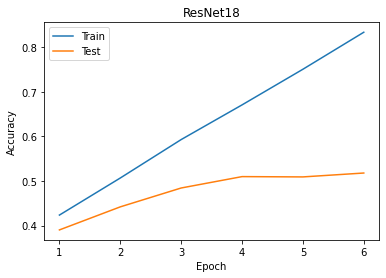

In [126]:
x_axis = np.arange(1, 7)

plt.plot(x_axis, train_accs, label='Train')
plt.plot(x_axis, test_accs, label='Test')

plt.legend()

plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.title('ResNet18')

plt.show()

In [127]:
train_a, train_p = get_accuracies(model, X_train_mfcc, y_train_mfcc)
test_a, test_p = get_accuracies(model, X_test_mfcc, y_test_mfcc)

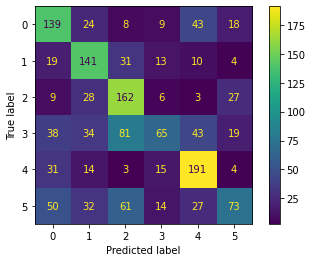

In [128]:
cm = confusion_matrix(y_test_mfcc, test_p)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [129]:
train_a, test_a

(0.833529312951453, 0.5177971793149765)

In [130]:
vgg = models.vgg16(pretrained=True)
vgg.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
vgg.classifier[6] = nn.Linear(in_features=4096, out_features=6, bias=True)

In [131]:
model = vgg.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00001)

train_accs = []
test_accs = []
label_ohe = F.one_hot(torch.tensor(y_train_mfcc), 6)
for e in range(6):
    for i in range(len(X_train_mfcc)):
        model.train()
        x = X_train_mfcc[i].type(torch.FloatTensor).to(device)
        y = label_ohe[i].type(torch.FloatTensor).to(device)

        scores = model(x).to(device)
        loss = F.cross_entropy(scores[0], y)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
    train_accs.append(get_accuracies(model, X_train_mfcc, y_train_mfcc)[0])
    test_accs.append(get_accuracies(model, X_test_mfcc, y_test_mfcc)[0])

    print('Epoch %d, loss = %.4f' % (e + 1, loss.item()))

Epoch 1, loss = 0.6648
Epoch 2, loss = 0.7601
Epoch 3, loss = 0.6150
Epoch 4, loss = 0.1405
Epoch 5, loss = 0.0562
Epoch 6, loss = 0.0634


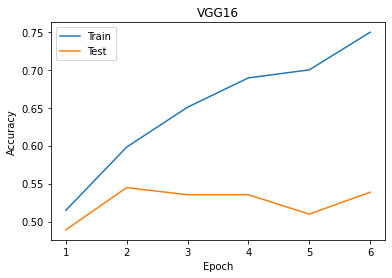

In [132]:
x_axis = np.arange(1, 7)

plt.plot(x_axis, train_accs, label='Train')
plt.plot(x_axis, test_accs, label='Test')

plt.legend()

plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.title('VGG16')

plt.show()

In [133]:
train_a, train_p = get_accuracies(model, X_train_mfcc, y_train_mfcc)
test_a, test_p = get_accuracies(model, X_test_mfcc, y_test_mfcc)

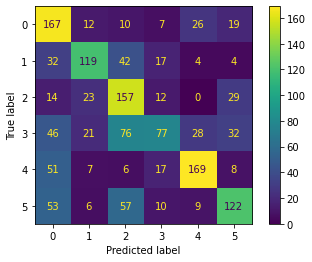

In [134]:
cm = confusion_matrix(y_test_mfcc, test_p)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [135]:
train_a, test_a

(0.7466823450361162, 0.544660846205507)

#### Transformer

In [136]:
r = T.Resize((224, 224))

In [137]:
vit_train = [r(s) for s in X_train_mfcc]
vit_test = [r(s) for s in X_test_mfcc]

In [138]:
vit = models.vit_b_16(pretrained=True)
vit.conv_proj = nn.Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
vit.heads.head = nn.Linear(in_features=768, out_features=6, bias=True)

In [139]:
model = vit.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00001)

train_accs = []
test_accs = []
label_ohe = F.one_hot(torch.tensor(y_train_mfcc), 6)
for e in range(6):
    for i in range(len(vit_train)):
        model.train()
        x = vit_train[i].type(torch.FloatTensor).to(device)
        y = label_ohe[i].type(torch.FloatTensor).to(device)

        scores = model(x).to(device)
        loss = F.cross_entropy(scores[0], y)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
    train_accs.append(get_accuracies(model, vit_train, y_train_mfcc)[0])
    test_accs.append(get_accuracies(model, vit_test, y_test_mfcc)[0])

    print('Epoch %d, loss = %.4f' % (e + 1, loss.item()))

Epoch 1, loss = 1.5575
Epoch 2, loss = 1.5866
Epoch 3, loss = 1.6277
Epoch 4, loss = 1.5770
Epoch 5, loss = 1.4011
Epoch 6, loss = 1.1142


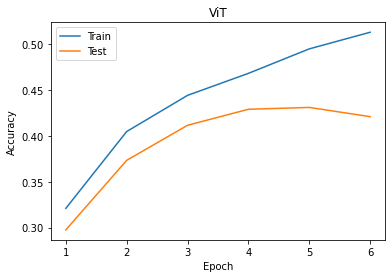

In [140]:
x_axis = np.arange(1, 7)

plt.plot(x_axis, train_accs, label='Train')
plt.plot(x_axis, test_accs, label='Test')

plt.legend()

plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.title('ViT')

plt.show()

In [141]:
train_a, train_p = get_accuracies(model, vit_train, y_train_mfcc)
test_a, test_p = get_accuracies(model, vit_test, y_test_mfcc)

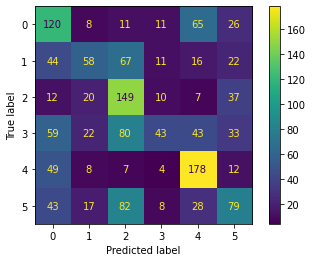

In [142]:
cm = confusion_matrix(y_test_mfcc, test_p)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [143]:
train_a, test_a

(0.5131866285906266, 0.4210879785090665)

In [144]:
1e-4

0.0001